In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as pyplt
import math
import timeit
import algorithms.geo_utils as geo_utils
import algorithms.areamanager as areamanager
from IPython.core.debugger import set_trace
%matplotlib inline
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)

CITY="madison"


In [2]:
df_checkin=pd.read_csv("../data/checkin/"+CITY+".csv",converters={'categories':string_to_array})
df_checkin['date']=pd.to_datetime(df_checkin['date'])
# users=df_checkin['user_id'].drop_duplicates().reset_index(drop=True)
# num_users=len(users)
df_checkin.set_index("user_id",inplace=True)
df_checkin.head()

,business_id,date,latitude,longitude,categories,subarea_id
user_id,,,,,,
MB7Z80PJxNyQM7keDpR2XQ,br1uQbc3YU5jCpYi46nIgQ,2018-04-04 00:09:03,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
4HwS2oCVQ1-f_kzHCv5X3A,br1uQbc3YU5jCpYi46nIgQ,2018-02-16 20:40:41,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
OLBH2Ds1wllrzpHlyojzJQ,br1uQbc3YU5jCpYi46nIgQ,2018-04-12 11:31:03,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
wd3xoNaDLib8dhQ7BxUl6g,br1uQbc3YU5jCpYi46nIgQ,2018-03-07 14:08:41,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0
4HwS2oCVQ1-f_kzHCv5X3A,br1uQbc3YU5jCpYi46nIgQ,2018-02-16 20:48:49,43.069425,-89.389567,"[Coffee & Tea, Cafes]",2064.0


In [3]:
users=df_checkin.index.drop_duplicates().to_list()

In [4]:
df_poi=pd.read_csv("../data/poi/"+CITY+".csv",converters={'categories':string_to_array})
df_poi=df_poi.set_index("business_id")

In [5]:
df_checkin.count()

business_id    52763
date           52763
latitude       52763
longitude      52763
categories     52763
subarea_id     52763
dtype: int64

### Centroide

In [6]:
df_checkin=df_checkin.reset_index().drop_duplicates(subset=['user_id','business_id']).set_index('user_id')

In [7]:
df_user_dist_mean=pd.DataFrame(columns=['user_id','dist_mean','subareas','categories'])
for user_id in df_checkin.index.drop_duplicates():
    subareas_id=set()
    df_user_checkin=df_checkin.loc[user_id]
    latitude,longitude=df_user_checkin[['latitude','longitude']].mean()
    dist_ac=0
    categories=set()
    for index,row in df_user_checkin[['latitude','longitude','subarea_id','categories']].iterrows():
        dist=geo_utils.haversine(latitude,longitude,row.latitude,row.longitude)
        dist_ac+=dist
        subareas_id.add(row['subarea_id'])
        categories.update(row['categories'])
    num_categories=len(categories)
    
    dist_mean=dist_ac/len(df_user_checkin)
    df_user_dist_mean=df_user_dist_mean.append({'user_id':user_id,'dist_mean':dist_mean,'subareas':len(subareas_id),'categories':num_categories},ignore_index=True)
df_user_dist_mean.head(2)

,user_id,dist_mean,subareas,categories
0,MB7Z80PJxNyQM7keDpR2XQ,4.151365,21,34
1,4HwS2oCVQ1-f_kzHCv5X3A,1.643125,26,53


In [8]:
df_user_dist_mean.describe()

,dist_mean
count,1022.000000
mean,4.589336
std,1.777380
min,0.326515
25%,3.293402
50%,4.637066
75%,5.758750
max,10.729046


Text(0, 0.5, 'distância (km)')

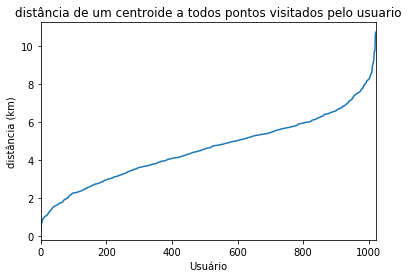

In [9]:
plt=df_user_dist_mean['dist_mean'].sort_values().reset_index(drop=True).plot(title='distância de um centroide a todos pontos visitados pelo usuario')
plt.set_xlabel("Usuário")
plt.set_ylabel("distância (km)")

Text(0, 0.5, 'subáreas')

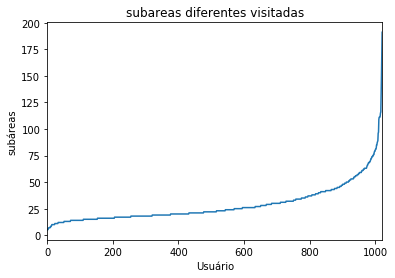

In [10]:
plt=df_user_dist_mean['subareas'].sort_values().reset_index(drop=True).plot(title='subareas diferentes visitadas')
plt.set_xlabel("Usuário")
plt.set_ylabel("subáreas")

In [11]:
#df_user_dist_mean[['dist_mean','subareas']].sort_values(by='dist_mean').reset_index(drop=True).plot.bar()

In [12]:
tmp=df_user_dist_mean[['dist_mean','subareas','categories']].sort_values(by='dist_mean').reset_index(drop=True)

tmp.head(2)

,dist_mean,subareas,categories
0,0.326515,5,49
1,0.645192,8,31


In [13]:
tmp.subareas.describe()

count     1022
unique      92
top         18
freq        65
Name: subareas, dtype: int64

Text(0.5, 0, 'Usuário')

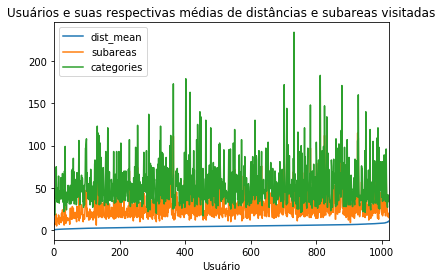

In [14]:
plt=tmp.plot()
plt.set_title("Usuários e suas respectivas médias de distâncias e subareas visitadas")
plt.set_xlabel("Usuário")

In [15]:
df_user_dist_mean=pd.DataFrame(columns=['dist_mean','subareas','categories'])
for x in range(0,len(users),100):
    meang=tmp.loc[x:x+100].mean()
    df_user_dist_mean=df_user_dist_mean.append(meang,ignore_index=True)

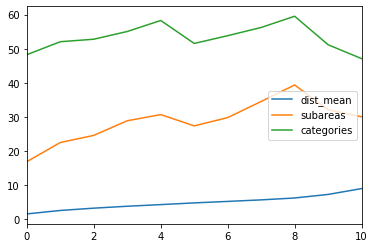

In [16]:
df_user_dist_mean.plot()

Text(0.5, 0, 'Grupos de usuários')

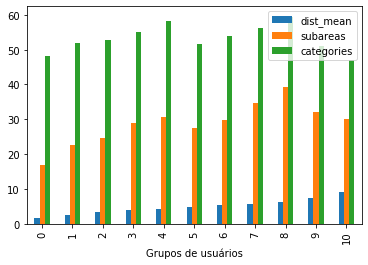

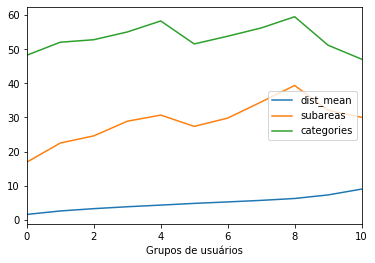

In [17]:
plt=df_user_dist_mean.plot.bar()
plt.set_xlabel("Grupos de usuários")
plt=df_user_dist_mean.plot()

plt.set_xlabel("Grupos de usuários")

In [18]:
df_group_mean=pd.DataFrame(columns=['subareas'])
i=0
for subareas in tmp['subareas']:
    if i % 50==49:
        df_group_mean=df_group_mean.append({'user_id':user_id,'dist_mean':dist_mean,'subareas':len(subareas_id)},ignore_index=True)
        
    i+=1

In [19]:
# correlação entre distancia e subareas
tmp['dist_mean'].corr(tmp['subareas'].apply(lambda x: np.float64(x)))

0.25895527776497523

In [20]:
tmp['dist_mean'].corr(tmp['categories'].apply(lambda x: np.float64(x)))

0.03552705318762428

Text(0.5, 0, 'Percentil')

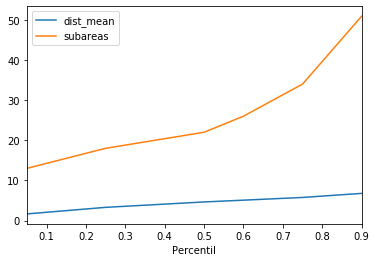

In [21]:
quantile_argument=[0.05, 0.25, 0.5, 0.6,0.75,0.9]
tmp.quantile(quantile_argument)
tmp['subareas'].quantile(quantile_argument)
plt=pd.concat([tmp.quantile(quantile_argument),tmp['subareas'].quantile([0.05, 0.25, 0.5, 0.6,0.75,0.9])],axis=1).plot()
plt.set_xlabel("Percentil")

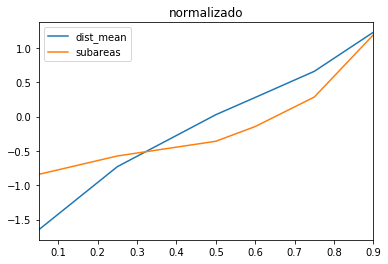

In [22]:
tmp_new=(tmp-tmp.mean())/tmp.std()
tmp_new.quantile(quantile_argument)
tmp_new['subareas'].quantile(quantile_argument)
pd.concat([tmp_new.quantile(quantile_argument),tmp_new['subareas'].quantile([0.05, 0.25, 0.5, 0.6,0.75,0.9])],axis=1).plot(title='normalizado')

Text(0.5, 1.0, 'Kernel Density Estimate usando Gaussian kernels, Distância média.')

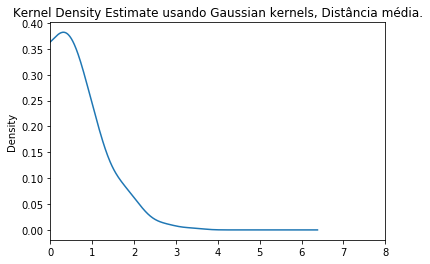

In [23]:
plt=tmp_new['dist_mean'].plot.kde()
plt.set_xlim(0,8)
plt.set_title("Kernel Density Estimate usando Gaussian kernels, Distância média.")

(0, 13)

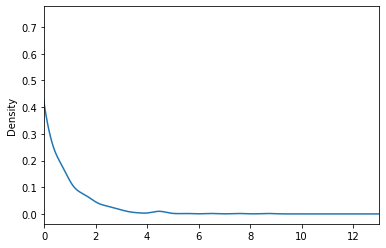

In [24]:
plt=tmp_new['subareas'].plot.kde()
plt.set_xlim(0,13)

Area selected: Madison
Correlação entre km andados e subareas visitadas: 0.11577830377277533
Correlação entre km andados e categorias: 0.03552705318762428
Subareas visitadas e categorias: 0.9294444152422031
Subáreas área 0.1km
Area selected: Madison
Correlação entre km andados e subareas visitadas: 0.16917161068448325
Correlação entre km andados e categorias: 0.03552705318762428
Subareas visitadas e categorias: 0.921829251077602
Subáreas área 0.2km
Area selected: Madison
Correlação entre km andados e subareas visitadas: 0.20164530480545098
Correlação entre km andados e categorias: 0.03552705318762428
Subareas visitadas e categorias: 0.9159382189497054
Subáreas área 0.3km
Area selected: Madison
Correlação entre km andados e subareas visitadas: 0.2345124060209652
Correlação entre km andados e categorias: 0.03552705318762428
Subareas visitadas e categorias: 0.9032526506733983
Subáreas área 0.4km
Area selected: Madison
Correlação entre km andados e subareas visitadas: 0.25895527776497523
C

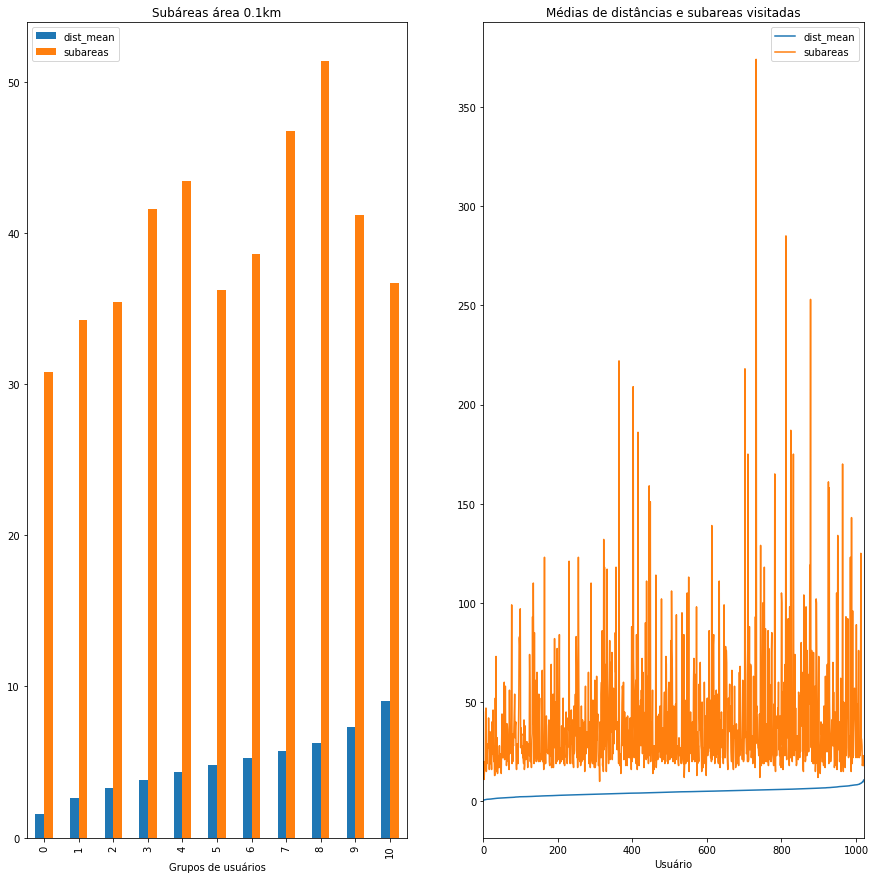

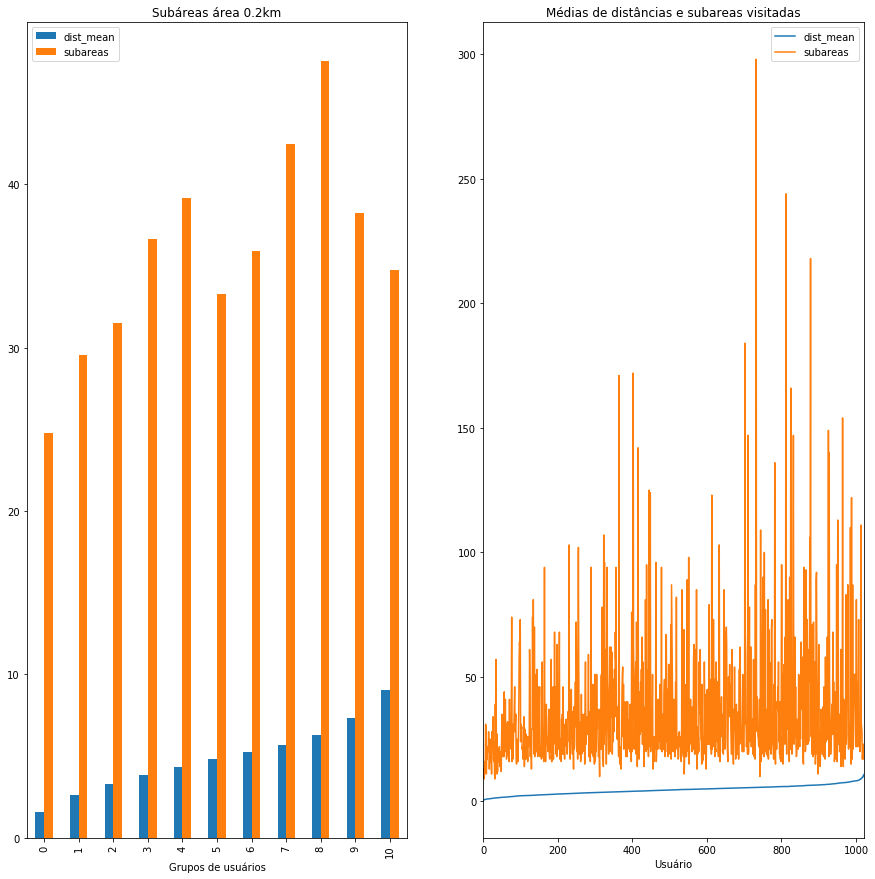

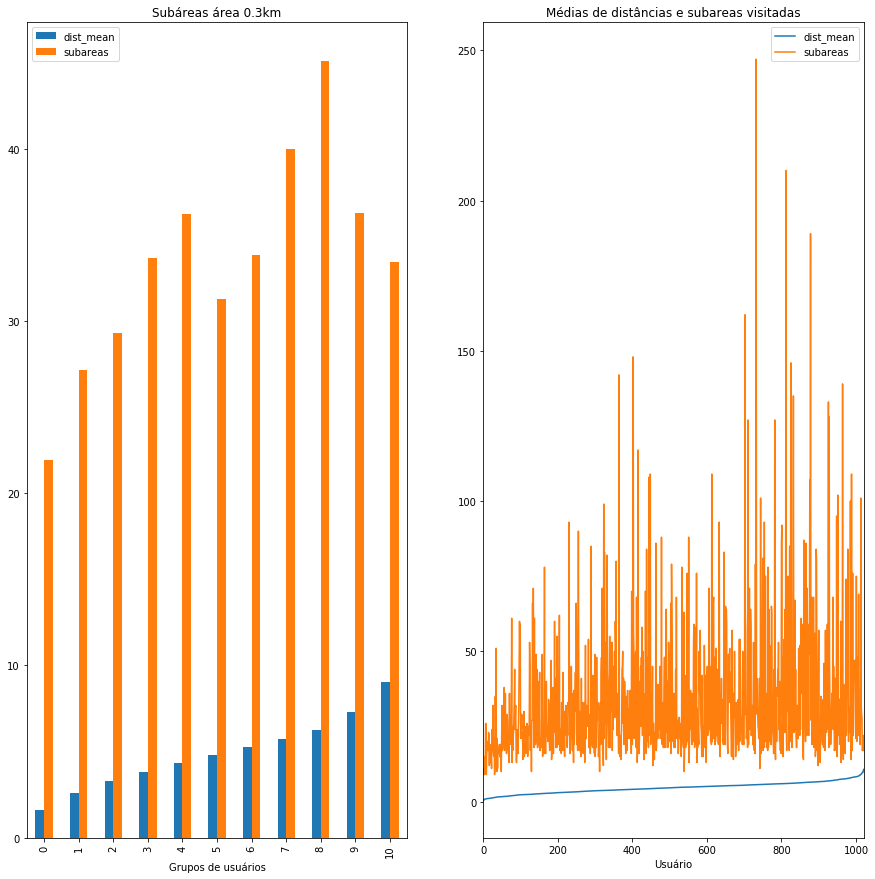

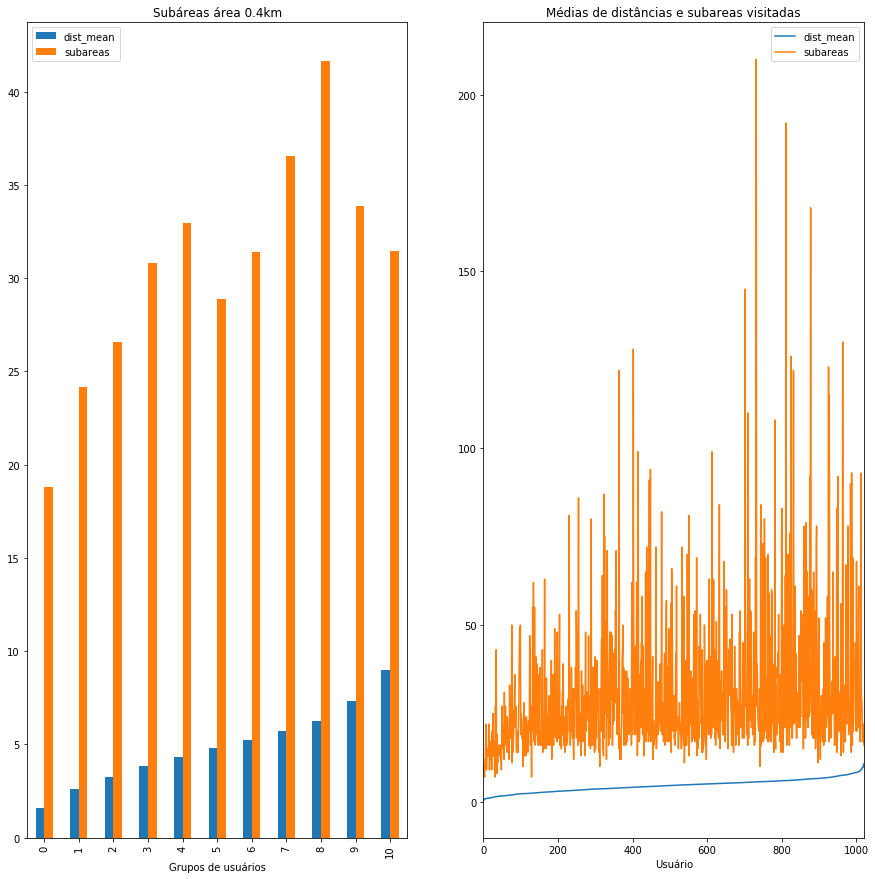

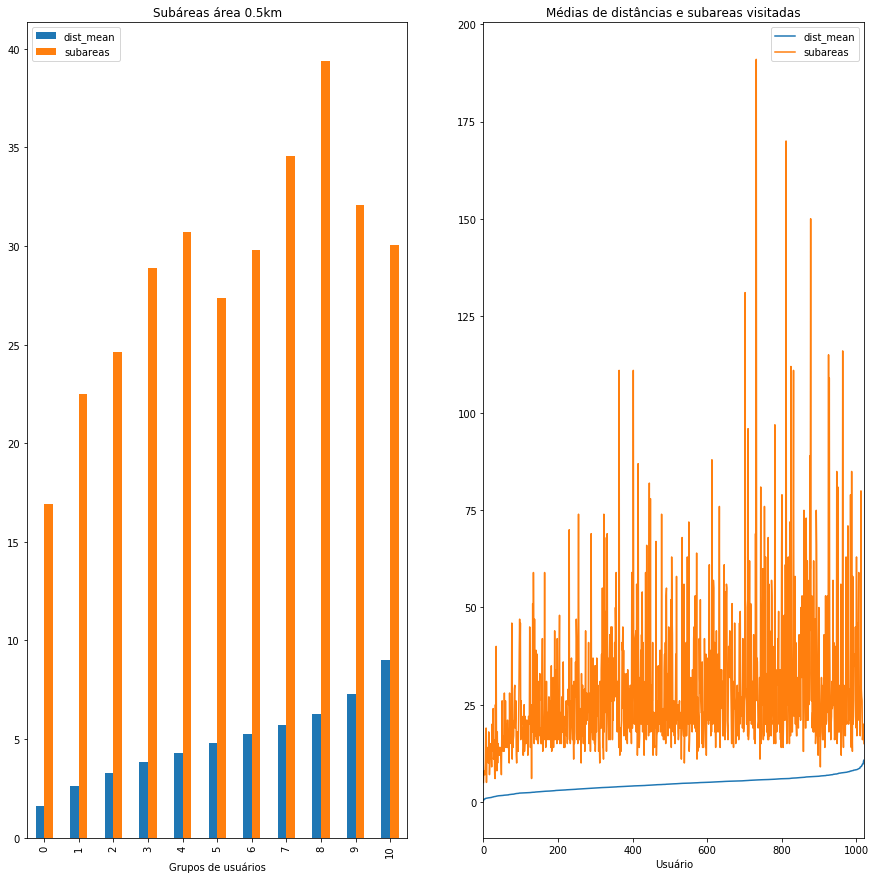

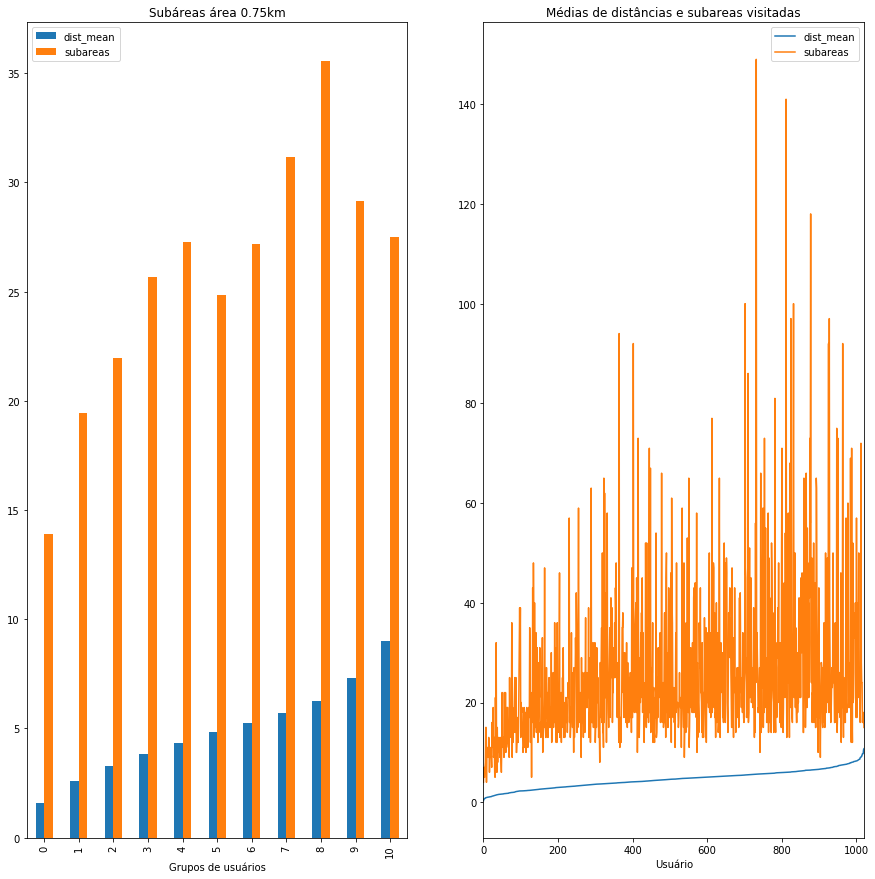

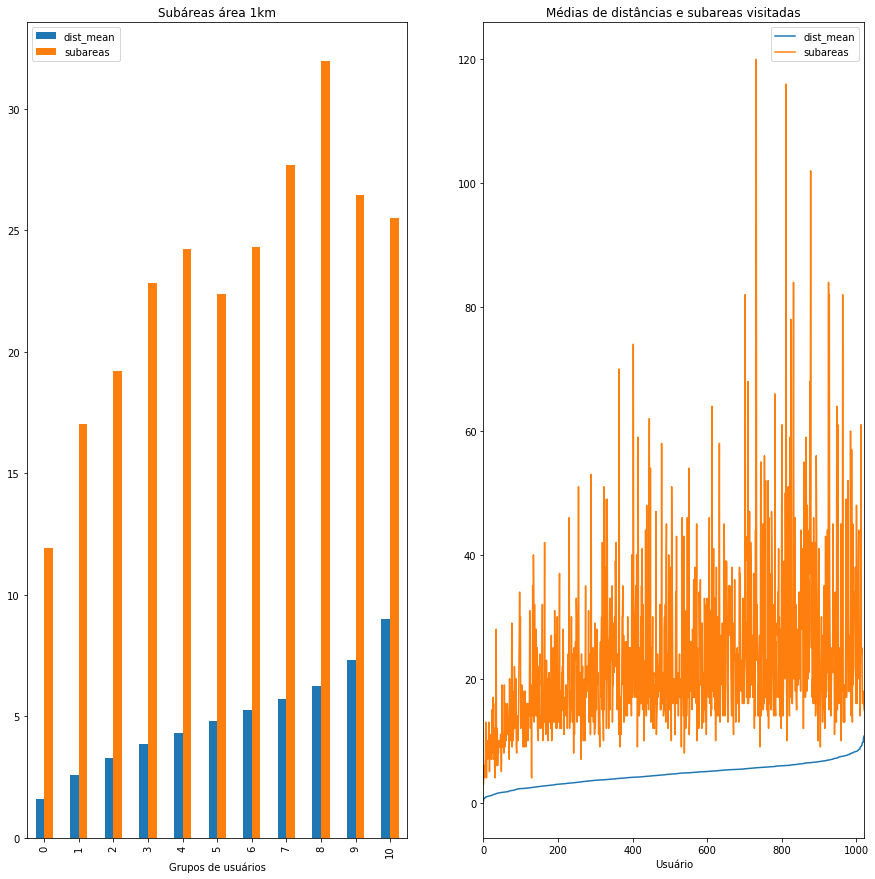

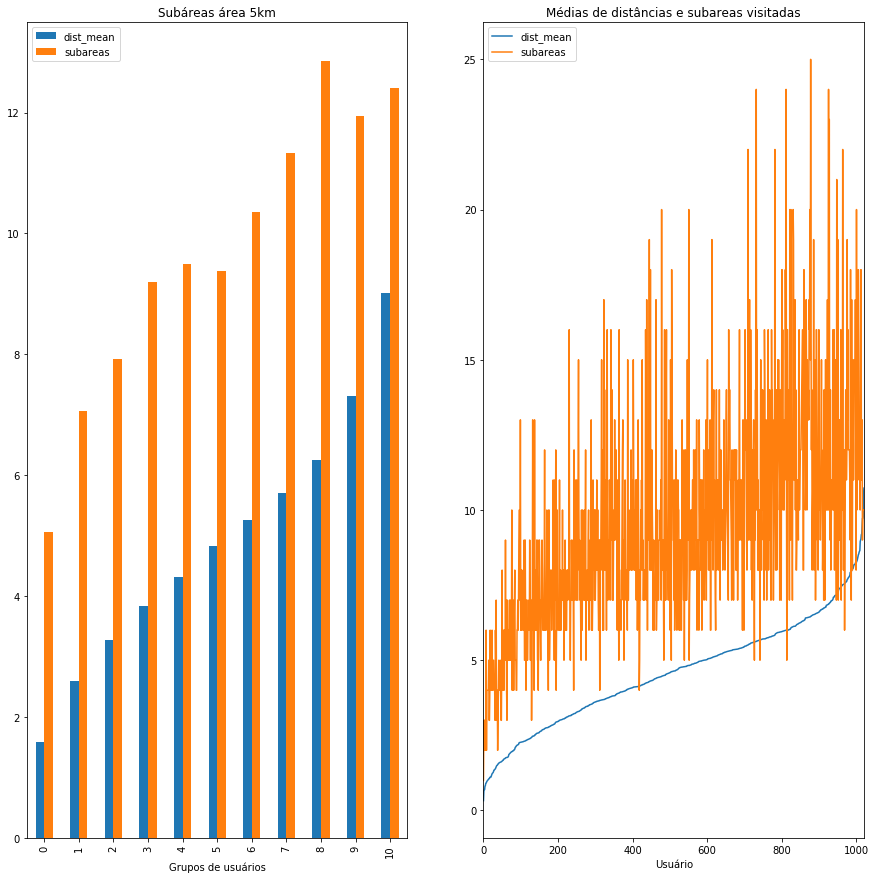

In [30]:
K =[0.1,0.2,0.3,0.4,0.5,0.75,1,5]

for subarea_km in K:
    areamanager.poi_set_subarea(areamanager.delimiter_area(CITY),df_checkin,subarea_km)
    df_user_dist_mean=pd.DataFrame(columns=['user_id','dist_mean','subareas','categories'])
    for user_id in df_checkin.index.drop_duplicates():
        subareas_id=set()
        df_user_checkin=df_checkin.loc[user_id]
        latitude,longitude=df_user_checkin[['latitude','longitude']].mean()
        dist_ac=0
        categories=set()
        for index,row in df_user_checkin[['latitude','longitude','subarea_id','categories']].iterrows():
            dist=geo_utils.haversine(latitude,longitude,row.latitude,row.longitude)
            dist_ac+=dist
            subareas_id.add(row['subarea_id'])
            categories.update(row['categories'])
        num_categories=len(categories)
        dist_mean=dist_ac/len(df_user_checkin)
        df_user_dist_mean=df_user_dist_mean.append({'user_id':user_id,'dist_mean':dist_mean,'subareas':len(subareas_id),'categories':num_categories},ignore_index=True)
    tmp=df_user_dist_mean[['dist_mean','subareas','categories']].sort_values(by='dist_mean').reset_index(drop=True)
    
    print("Correlação entre km andados e subareas visitadas:",tmp['dist_mean'].corr(tmp['subareas'].apply(lambda x: np.float64(x))))
    print("Correlação entre km andados e categorias:",tmp['dist_mean'].corr(tmp['categories'].apply(lambda x: np.float64(x))))
    print("Subareas visitadas e categorias:",(tmp['categories'].apply(lambda x: np.float64(x))).corr(tmp['subareas'].apply(lambda x: np.float64(x))))
    tmp=tmp[['dist_mean','subareas']]
    df_group_dist_mean=pd.DataFrame(columns=['dist_mean','subareas'])
    for x in range(0,len(users),100):
        meang=tmp.loc[x:x+100].mean()
        df_group_dist_mean=df_group_dist_mean.append(meang,ignore_index=True)
        
    fig, axes = pyplt.subplots(nrows=1, ncols=2,figsize=(15,15))
    
    group_str="Subáreas área "+str(subarea_km)+"km"
    print(group_str)
    plt=df_group_dist_mean.plot.bar(ax=axes[0])
    plt.set_title(group_str)
    plt.set_xlabel("Grupos de usuários")
    
    plt=tmp.plot(ax=axes[1])
    plt.set_title("Médias de distâncias e subareas visitadas")
    plt.set_xlabel("Usuário")



    